# Genetic Algorithms

\textit{Section completed by: Adam Lawson Parkinson} 

Genetic Algorithms are based on the ideas of natural selection. They are primarily used for optimisation and search problems.
Generally, they use three "biological" operators: mutation, crossover and selection <sup>[[1]](https://doi.org/10.1016/B978-0-12-821986-7.00013-5)</sup>.

A genetic algorithm requires
- a representation of all the "chromosomes" in a population
- a fitness function

A general outline of the algorithm is as follows:
1. Initialise a random population
2. Selection of "chromosomes" to reproduce
3. Apply genetic operators
4. Termination

Steps 2 and 3 are repeated until an acceptable solution is found.

## Applications
Genetic algorithms can be applied to various problems, such as timetabling and scheduling, the travelling salesman problem, solving sudokus and hyperperameter optimisation.

Ideas such as elitism can be used to further improve genetic algorithms, however they do have some limitations.

- They rely heavily on the fitness function to evaluate each solution
- They have a tendency to converge to a local optima
- They don't scale well with complexity

In this section, we'll be using a Genetic Algorithm to solve the travelling salesman problem.
We're asking the question "What is the shortest route between a list of cities that visits each city exactly once and returns to the origin city?"

We will model each city as a point in the X-Y plane and the distance between them as the euclidean distance between the two points. We will always start and finish at the origin, (0,0).

In [1]:
# Import numpy and seed random
import numpy as np
np.random.seed(0)

# Import time for comparisons
from time import time

In [2]:
# Create a list of n_nodes random nodes
def create_nodes(n_nodes):
    nodes = []
    for _ in range(n_nodes):
        nodes.append((np.random.randint(0,1000), np.random.randint(0,1000)))

    return nodes

# Set up our example
nodes = create_nodes(10)

In [3]:
# TSP Class
# Contains all the methods we need for the algorithm
class TSP:
    # Initialise class given a list of nodes and origin
    def __init__(self, nodes, origin=(0,0), rand=True):
        self.n = len(nodes)
        self.origin = origin
        self.nodes = nodes.copy()
        
        # Randomise order of list to create random solutions to TSP
        if rand:
            np.random.shuffle(self.nodes)

    # Convert to string representation
    def __str__(self):
        return str(self.nodes)

    # Check if two solutions are "equal", aka they have the same score. Used when sorting items in a list
    def __eq__(self, other):
        return self.get_score() == other.get_score()

    # Check if one solution is greater than the other, used for sorting items in a list
    def __gt__(self, other):
        return self.get_score() > other.get_score()

    # Find the distance between two nodes.
    def get_dist(self, a, b):
        # Euclidean distance
        return np.sqrt((a[0] - b[0])**2 + (a[1] - b[1])**2)

    # Get the current score of the solution
    def get_score(self):
        # Calculate the distance of our path and then add the distance between the origin and the first node and the origin and the last node
        total = 0
        for i in range(1, self.n - 1):
            total += self.get_dist(self.nodes[i-1], self.nodes[i])

        total += self.get_dist(self.origin, self.nodes[0]) + self.get_dist(self.nodes[self.n - 1], self.origin)
        return total

    # Return list of nodes in order
    def get_nodes(self):
        return self.nodes

    # Mutate the solution. Randomly swap two nodes.
    def mutate(self):
        i = np.random.randint(0,self.n)
        j = np.random.randint(0,self.n)
        self.nodes[i], self.nodes[j] = self.nodes[j], self.nodes[i]

    # Add two solutions together. Cut a section from one list and insert it into the other.
    # Allows us to use the + operator
    def __add__(self, x):
        # AKA crossover
        x_nodes = x.get_nodes()

        # Cut start and end
        cut = [np.random.randint(1,self.n), np.random.randint(1,self.n)]
        cut_s = min(cut)
        cut_e = max(cut)
        
        child = [None]*self.n
        
        for i in range(cut_s, cut_e):
            child[i] = x_nodes[i]

        # Avoid duplicates
        for i in range(self.n):
            if child[i] == None:
                for j in range(self.n):
                    if not self.nodes[j] in child:
                        child[i] = self.nodes[j]
            
        return TSP(child, self.origin, False)

    # Copy a solution to a new object
    def copy(self):
        return TSP(self.nodes, self.origin, False)


In [4]:
# GA paramaters

P = 64 # Population size
N = 1000 # Number of generations
E = 1 # Number of best solutions to keep (elitism)
R = int(P / 16) # Number of random solutions to introduce
M = int(P/4) + 1 # Number of solutions to mutate

origin = (0,0) # Start and end node

# Our genetic algorithm function
def ga(nodes, verbose = False):

    # Time solution
    start_time = time()
    
    # Create an initial population
    population = []
    for _ in range(P):
        population.append(TSP(nodes))
    
    # Sort the population by score, lowest scoring (best) first
    population.sort()

    # Start training loop
    for g in range(N):
        
        # Create weights to prioritise better solutions for selection
        weights = [(P - x)/(0.5*P*(P+1)) for x in range(P)]
        children = []

        # Crossover
        for _ in range(P - E - R - M):
            # Choose two chromosomes from the population, the first one is more likely to be a good solution as it is weighted
            reproducers = [np.random.choice(population, 1, p=weights)[0], np.random.choice(population, 1)[0]]

            # Combine solutions using crossover to produce a child
            child = reproducers[0] + reproducers[1]
            children.append(child)

        # Introduce R new random solutions
        for _ in range(R):
            child = TSP(nodes, origin)
            children.append(child)

        # Mutations
        for _ in range(M):
            # Randomly choose a chromosome for mutation
            child = np.random.choice(population,1)[0].copy()
            child.mutate()
            children.append(child)

        # Elitism - keep the best solutions
        for e in range(E):
            children.append(population[e])

        
        population = children.copy()

        # Sort the population so that the best solution has index 0.
        population.sort()

        # Print score
        if verbose and g % 50 == 0:
            print("Current best weight: " + str(population[0].get_score()))

    # Get the best solution
    best_nodes = population[0].get_nodes()

    # Find the time taken
    end_time = time()
    ga_time = end_time - start_time

    # Return the best solution, score and time taken
    return best_nodes, population[0].get_score(), ga_time

ga_best_nodes, ga_best_score, ga_time = ga(nodes, True)
print("\n")
print("Best solution weight: ", str(ga_best_score))
print("Time taken: " + str(ga_time) + "s")

Current best weight: 3339.9685930447476
Current best weight: 2869.605202996355
Current best weight: 2829.9249510504214
Current best weight: 2829.9249510504214
Current best weight: 2829.9249510504214
Current best weight: 2829.9249510504214
Current best weight: 2829.9249510504214
Current best weight: 2829.9249510504214
Current best weight: 2829.9249510504214
Current best weight: 2829.9249510504214
Current best weight: 2829.9249510504214
Current best weight: 2829.9249510504214
Current best weight: 2829.9249510504214
Current best weight: 2764.5200599396853
Current best weight: 2764.5200599396853
Current best weight: 2764.5200599396853
Current best weight: 2764.5200599396853
Current best weight: 2764.5200599396853
Current best weight: 2764.5200599396853
Current best weight: 2764.5200599396853


Best solution weight:  2764.5200599396853
Time taken: 20.057474851608276s


In [5]:
# Brute force approach.
# Used for comparison against the genetic algorithm for running time and indicator of how good the GA solutions are.
from sys import maxsize 
from itertools import permutations

def brute_force(nodes):
    # Start time of algorithm
    start_time = time()
    
    N = len(nodes)
    
    # Find the distance between a and b
    def dist(a, b):
        return np.sqrt((a[0] - b[0])**2 + (a[1] - b[1])**2)
    
    # store all vertex apart from source vertex 
    # store minimum weight Hamiltonian Cycle 
    best_path_weight = maxsize 
    all_permutations = permutations(nodes)
    best_path = None

    # Iterate through every permutation
    for permutation in all_permutations:
     
        # store current Path weight(cost) 
        current_pathweight = 0
     
        # Calculate the distance of our path and then add the distance between the origin and the first node and the origin and the last node
        for i in range(1, N - 1):
            current_pathweight += dist(permutation[i-1], permutation[i])
    
        current_pathweight += dist(origin, permutation[0]) + dist(permutation[N - 1], origin)
     
        # update minimum 
        best_path_weight = min(best_path_weight, current_pathweight)
        if best_path_weight == current_pathweight:
            best_path = permutation

    # Calculate running time
    end_time = time()
    
    bf_time = end_time - start_time

    return best_path, best_path_weight, bf_time

best_path, bpw, bft = brute_force(nodes)
print("Best solution weight: ", str(bpw))
print("Time taken: " + str(bft) + "s")

Best solution weight:  2753.279654642227
Time taken: 48.84818983078003s


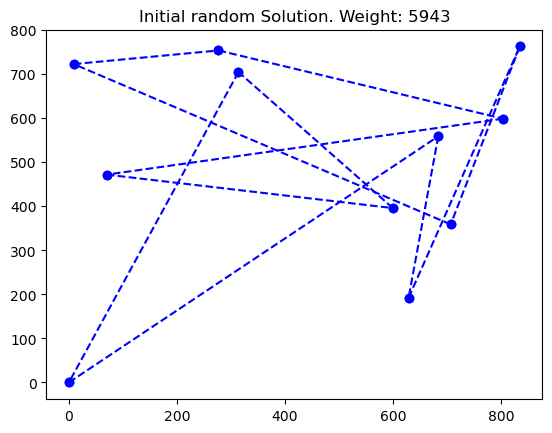

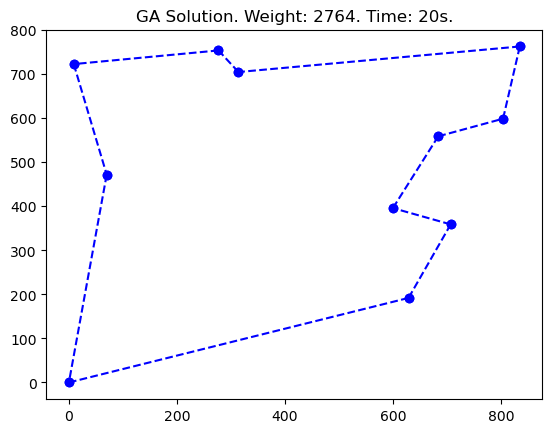

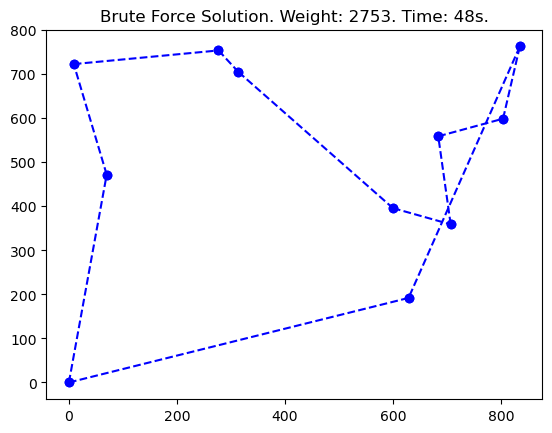

In [6]:
# Plot graphs
import matplotlib.pyplot as plt


# Plot the initial random solution
# Create initial x,y lists with origin and first node
x_values = [0, nodes[0][0]]
y_values = [0, nodes[0][1]]
plt.plot(x_values, y_values, 'bo', linestyle="--")

# Plot each pair with a line connecting them
for n_i in range(len(ga_best_nodes) - 1):
    x_values = [nodes[n_i][0], nodes[n_i + 1][0]]
    y_values = [nodes[n_i][1], nodes[n_i + 1][1]]
    plt.plot(x_values, y_values, 'bo', linestyle="--")

# Finally plot the line from the last node to the origin
x_values = [nodes[len(nodes) - 1][0], 0]
y_values = [nodes[len(nodes) - 1][1], 0]
plt.plot(x_values, y_values, 'bo', linestyle="--")

# Add a title and show the plot
plt.title("Initial random Solution. Weight: " + str(int(TSP(nodes, origin, False).get_score())))
plt.show()


# Plot the solution found by the GA - uses the same method as above
x_values = [0, ga_best_nodes[0][0]]
y_values = [0, ga_best_nodes[0][1]]
plt.plot(x_values, y_values, 'bo', linestyle="--")

for n_i in range(len(ga_best_nodes) - 1):
    x_values = [ga_best_nodes[n_i][0], ga_best_nodes[n_i + 1][0]]
    y_values = [ga_best_nodes[n_i][1], ga_best_nodes[n_i + 1][1]]
    plt.plot(x_values, y_values, 'bo', linestyle="--")

x_values = [ga_best_nodes[len(ga_best_nodes) - 1][0], 0]
y_values = [ga_best_nodes[len(ga_best_nodes) - 1][1], 0]
plt.plot(x_values, y_values, 'bo', linestyle="--")
plt.title("GA Solution. Weight: " + str(int(ga_best_score)) + ". Time: " + str(int(ga_time)) + "s.")
plt.show()


# Plot the optimal solution found by the genetic algorithm - uses the same method as above
x_values = [0, best_path[0][0]]
y_values = [0, best_path[0][1]]
plt.plot(x_values, y_values, 'bo', linestyle="--")

for n_i in range(len(best_path) - 1):
    x_values = [best_path[n_i][0], best_path[n_i + 1][0]]
    y_values = [best_path[n_i][1], best_path[n_i + 1][1]]
    plt.plot(x_values, y_values, 'bo', linestyle="--")

x_values = [best_path[len(best_path) - 1][0], 0]
y_values = [best_path[len(best_path) - 1][1], 0]
plt.plot(x_values, y_values, 'bo', linestyle="--")
plt.title("Brute Force Solution. Weight: " + str(int(bpw)) + ". Time: " + str(int(bft)) + "s.")
plt.show()

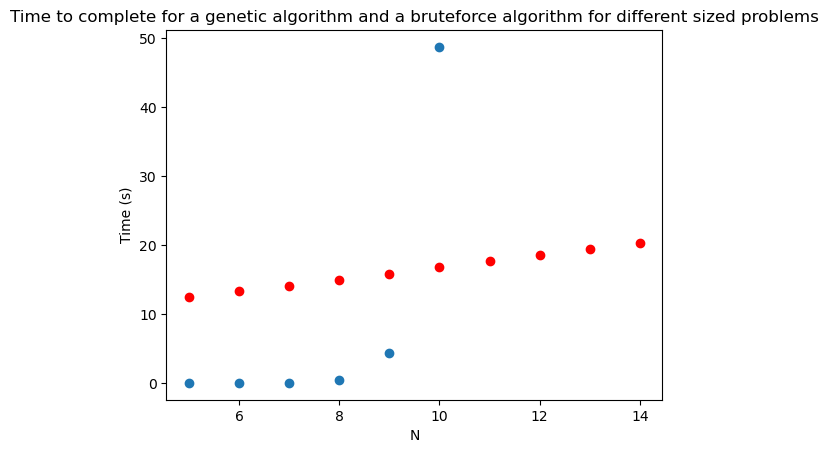

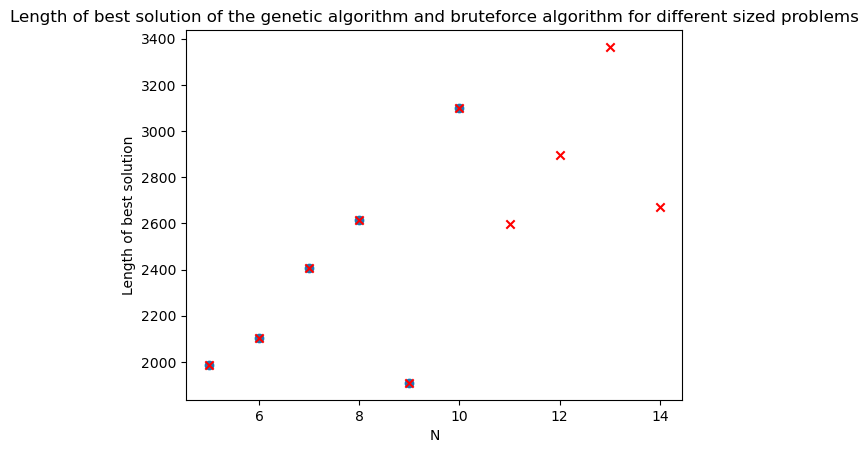

In [7]:
# Compare the minimum solution and running time between Genetic Algorithm and Brute Force Algorithm for different sized problems


# Create lists to hold results
times_ga = []
times_bf = []

sol_ga = []
sol_bf = []

n_ga = []
n_bf = []

# Solve for n between 5 and 15
for n in range(5,15):
    # Create problem
    nodes = create_nodes(n)

    # Only use brute force approach if n < 11 as otherwise running time is too high
    if n < 11:
        best_path, bpw, bft = brute_force(nodes)

        times_bf.append(bft)
        sol_bf.append(bpw)
        n_bf.append(n)

    # Solve using GA
    ga_best_nodes, ga_best_score, ga_time = ga(nodes)
    
    times_ga.append(ga_time)
    sol_ga.append(ga_best_score)
    
    n_ga.append(n)


# Plot scatter graph for running time

plt.scatter(n_bf, times_bf)
plt.scatter(n_ga, times_ga, c="red")
plt.title("Time to complete for a genetic algorithm and a bruteforce algorithm for different sized problems")
plt.xlabel("N")
plt.ylabel("Time (s)")

plt.show()

# Plot scatter graph for solution

plt.scatter(n_bf, sol_bf)
plt.scatter(n_ga, sol_ga, c="red", marker="x")
plt.title("Length of best solution of the genetic algorithm and bruteforce algorithm for different sized problems")
plt.xlabel("N")
plt.ylabel("Length of best solution")

plt.show()

The genetic algorithm takes a long time for small problems because we don’t terminate early. In a real life situation we would be able to terminate much earlier leading to a smaller running time for smaller problems.
You can see from the first graph that the genetic algorithm can still find solutions to larger problems when a brute force approach would be infeasible. 
In the second graph, it is clear that the genetic algorithm still finds optimal solutions to smaller problems and is still finding good solutions for larger problems.

## References
[1] [Xin-She Yang *Nature-Inspired Optimization Algorithms (Second Edition)* 2021](https://doi.org/10.1016/B978-0-12-821986-7.00013-5)